# 4 Messaging in multi-agent systems

In the previous notebooks in this session, you have seen how we can pull data collected in the simulator into the notebook's Python environment, and then analyse it in that environment at our convenience.

In particular, we could convert the raw data to an image based representation, as well as presenting in as raw data to a pre-trained multilayer perceptron (MLP) or a pre-trained convolutional neural network (CNN).

We could also capture and decode test labels for the images, allowing is to train a classifier neural network purely using information retrieved from the simulated robot.

To simplify data collection matters in the original experiments, we "teleported" the robot to specific sampling locations, rather than expecting it to explore the environment and try to detect images on its own.

In the previous notebook, you saw how we could collect data "on the move", getting the robot to drive over a set of test images and collecting the data as it did so. We then retrieved this data from a synchronised data log in the Python environment when we had completed the data collection activity.

In this notebook, we will try to make things even more dynamic. In particular, we will make use of a communication mechanism where the robot can send data back to the notebook environment for analysis, and then when the analysis is complete, have a message sent from the notebook Python environment back to the robot identifying how a potential image was classified.

## 4.1 ROS — the Robot Operating System

*ROS*, the *Robot Operating System*, provides one possible architecture for implementing a dynamic message passing architecture. In a ROS environment, separate *nodes* publish details of one or more *services* they can perform along with *topics* that act act as the nodes address that other nodes can subscribe. Nodes then pass messages between each other in order to perform a particular task. The ROS architecture is rather elaborate for our needs, however, so we shall use a much simpler and more direct approach.

*How messages are exchanged is governed by a `protocol` that defines what the messages mean, and how the agents should take turns in sending and receiving.*

*The protocol should also handle cases where messages get lost, since no communication channel is fully reliable. For example, infrared messages could be lost if the robot wanders out of range or just faces the wrong way.*

The approach we will use, although much simpler approach than the full ROS architecture, will also be based on a message passing approach. To implement the communication system, we need to define a "message" handler in the notebook's Python environment that can accept messages sent from the simulated robot, perform some sort of analysis task on the received data, and then provide a response back to the simulated robot.

### 3.1.1 Communicating between the notebook and the robot

A simple diagram helps to explain the architecture we are using.

We'll create the diagram using the `%%blockdiag` magic you met previously. Let's load it in and enable it first:

In [1]:
%load_ext blockdiag_magic

From the written image description in the following code cell, can you visualise in your mind's eye what the simplified architecture looks like?

Run the following cell to generate the image:

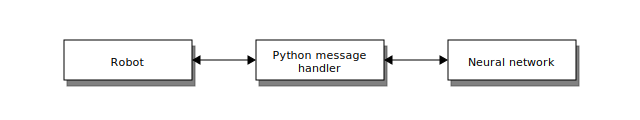

In [2]:
%%blockdiag

robot [label = "Robot"];
python [label = "Python message\nhandler"];
mlp [label = "Neural network"];



robot <-> python <-> mlp;

The diagram shows three boxes:

- the first box, labled *Robot*, is connected by a double ended arrow to the second box, labeled *Python message handler*; (the `\n` character in the second label represents a line break);
- the second box is connected by another double ended arrow to the third box, labeled *Neural network*.

The figure is intended to convey the idea that the robot sends a message to a message handler running in the notebook's Python environment, which presents the decoded message contents to a neural network. The network classifies the data, passes the classification "back" to the message handler, and this in turn passes a response message back to the simulated robot.

### 3.1.2  Defining a simple message handler

Inside the robot, a simple mechanism is already defined that allows the robot to send a message to the Python environment, but there is nothing defined on the Python end to handle it.

To set it up, load the simulator in the normal way:

In [3]:
#Get the simulator
from nbev3devsim.load_nbev3devwidget import roboSim, eds
%load_ext nbev3devsim

<IPython.core.display.Javascript object>

Ev3DevWidget(status='deferring flush until render')

From the settings menu in the simulator, enable the *Collaborative* option. Alternatively, using the `--collab / -L` magic flag:

In [4]:
%sim_magic --collab -HWZ

Enabling the *Collaborative* mode means that when messages are printed to the simulator output window prefixed by the label `PY::`, they are also passed to the Python environment.

We can create custom handlers on the Python notebook side that can pick up messages sent from the simulator and return a response to the simulator.

We do this in three steps.

First, we define a function that can *parse* messages sent from the robot. We can use a *regular expression* to help us parse the original message (`re.search()`), and then use a very unsafe method (`eval()`) to try to parse the message as a Pyhton data structure.

*You are not expected to be able to create your own regular expressions in order to successfully complete the module.*

In [5]:
import re

def simple_parser(msg):
    """Simple message parser."""
    # Match messages that start "PY::"
    match = re.search(r'^PY::(.+)', msg)
    if match:
        matches = match.groups()
        # Get the matched text string
        match_str = matches[0]
        # Try to cast it to a Python object
        # Note - this is very insecure and not
        # a secure thing to do!
        try:
            obj = eval(match_str)
        except:
            obj = match_str
        return obj
    # No match, so return None
    return None

parser = simple_parser

*Regular expression pattern matchers capable of matching particular string patterns are found in many programming languages.*

*Regular expressions use a special vocabulary of terms for matching string elements, including `^` to represent the start of a string, `.` to represent any character, `+` to represent one or more of the preceding character, and ` * ` to represent zero or more of the preceding character. Bracketed items can be "captured" into matched groups.*

*Covering regular expressions in any further detail is outside the scope of this module.*

Run the following code cell to test the simple parser agent against various text messages. *Feel free to come up with your own test messages.*

In [6]:
test_messages = ["PY::1",
                 "PY::[1, 2, 3]",
                 "PY:: {'int': 1, 'str': 'string'}",
                 "PY::my message",
                 "my message"
                 ]

for msg in test_messages:
    print(f'Original: {msg}')
    if simple_parser(msg):
        print(f'Parsed: {simple_parser(msg)}')
        print(f'Type: {type(simple_parser(msg))}\n')

Original: PY::1
Parsed: 1
Type: <class 'int'>

Original: PY::[1, 2, 3]
Parsed: [1, 2, 3]
Type: <class 'list'>

Original: PY:: {'int': 1, 'str': 'string'}
Parsed: {'int': 1, 'str': 'string'}
Type: <class 'dict'>

Original: PY::my message
Parsed: my message
Type: <class 'str'>

Original: my message


Notice how the parser takes the message and then tries to parse it as Python objects where it can. This includes casting items to numerical integers, lists, dictionaries and, the final default type, strings.

Second, we need to define a `responder()` function. This function should accept a message object, parse it, do something with it, and provide a response.

We'll also add an ability to log what the Python side sees and returns in a log file, `logger.txt`.

*The `seqdiag` block magic is of a similar kind to the `blockdiag` magic and creates another diagram type, in this case a __sequence diagram__. The diagram shows how messages are passed in order between different actors in a a communication system.*

*Time starts at the top of the diagram and increases as you read down the diagram. The arrows show how messages pass from one actor to another. The increasing time dimension highlights the sequential order in which messages are passed.*

Our protocol will look something like the following (run the code cell to render the sequence diagram):

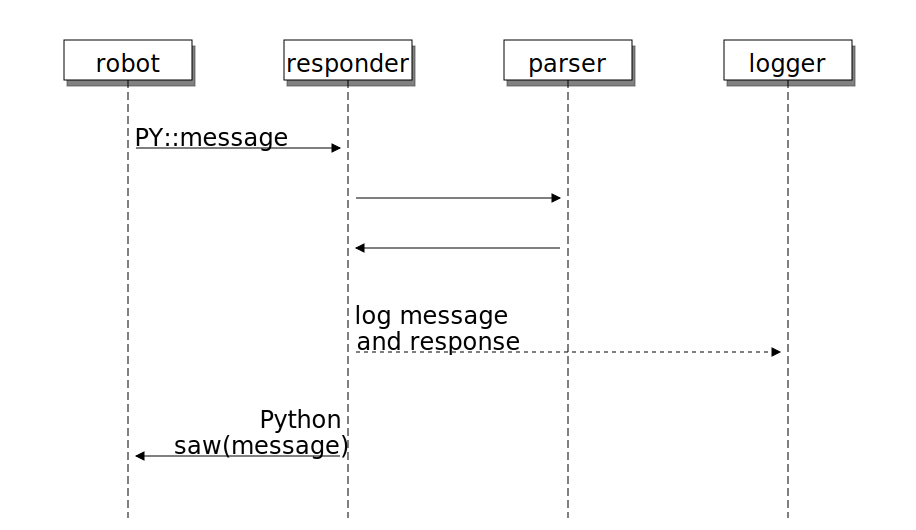

In [7]:
%%seqdiag
default_fontsize = 24;
edge_length = 220;
activation = none;

robot  -> responder [label = "PY::message"];
responder -> parser;
responder <- parser;
responder --> logger [label = "log message\nand response"];
robot <- responder [label = "Python\nsaw(message)"];

In the sequence diagram, the *robot* passes a message to the *responder*, which handles the message by passing it to a *parser*. The parsed message is returned to the *responder*, which creates an entry in a *logger* log file and sends a response back to the *robot*. 

The following command will clear the logfile if it has already been written to:

In [8]:
%%writefile logger.txt
# Responder logfile
# -----------------

Overwriting logger.txt


For the responder itself, this might be as simple as returning a message that essentially echoes the parsed message passed to the function with a simple text wrapper: 

In [9]:
def logger(msg, response):
    """Create a simple logfile output."""
    # Log the response to a file
    with open('logger.txt', 'a') as f:
        f.write(f'Received message: {msg}\n')
        f.write(f'Response: {response}\n')
        f.write(f'---\n')


def echo_responder(msg_object):
    """Echo the original message in a simple message."""
    # Parse the message
    msg = parser(msg_object)

    # Do something with the message here...
    response = f'Python saw >> {msg} << that...'

    # Write to the logger
    logger(msg, response)

    # Return the response
    return response

The third thing we need to do is configure the `roboSim` Python object to use the `responder()` function we have just defined as the message handler. This will handle messages sent from the simulated robot (that is, messages starting with `PY::` that are `print`ed to the output window with the simulator in *Collaborative* mode).

In [10]:
roboSim.pyresponder = echo_responder

# Flush any garbage already on the line...
%sim_magic --refresh

Clear the logfile:

In [11]:
%%writefile logger.txt
# Responder logfile
# -----------------

Overwriting logger.txt


Now we should be able to send messages from the robot to the Python environment, handle them on the Python side, and then send a response back to the robot. The message sent back to the robot is displayed in the output window:

In [12]:
%%sim_magic_preloaded -ROHW --collab
import time

for i in range(5):
    
    print("Robot says", str(i))
    if not i%2:
        print("PY::"+str(i))
        
    # We need some physical time to elapse
    # to give time for the messages to propagate
    time.sleep(1)

say("all done")

Wait until the program has completed its run (you should hear it say *All done* at the end).

If you now review the contents of the simulator outpur window, you can see how the robot starts by sending  a message:

`PY::0`

and the Python process then responds:

`Python saw >> 0 << that...`

The robot then sends several further messages that the Python agent responds to appropriately.

We can also view the logfile to see a report from the Python side of the transaction:

In [13]:
%cat logger.txt

# Responder logfile
# -----------------
Received message: 0
Response: Python saw >> 0 << that...
---
Received message: 2
Response: Python saw >> 2 << that...
---
Received message: 4
Response: Python saw >> 4 << that...
---


### 3.1.3 Passing state

Passing messages is all very well, but can we go a step further? Can we pass *data objects* between the robot and the Python environment, and back again?

Let's start by adding another level of indirection to out program. In this case, let's create a simple agent that takes a parsed message object, does something to it (which in this case isn't very interesting!) and passes a modified object back:

In [14]:
def simple_echo_agent(msg):
    """Simple echo agent."""
    
    # Suppose we have a dictionary response
    # Just echo that back
    return f'Py saw: {msg}'

agent = simple_echo_agent

The following responder works in the following way:

- it parses a message received from the robot;
- it passes the parsed message to an agent, which does something with it;
- it gets a response back from the agent;
- it encodes the agent's response it so that it can be used in out message protocol;
- it responds to the robot.

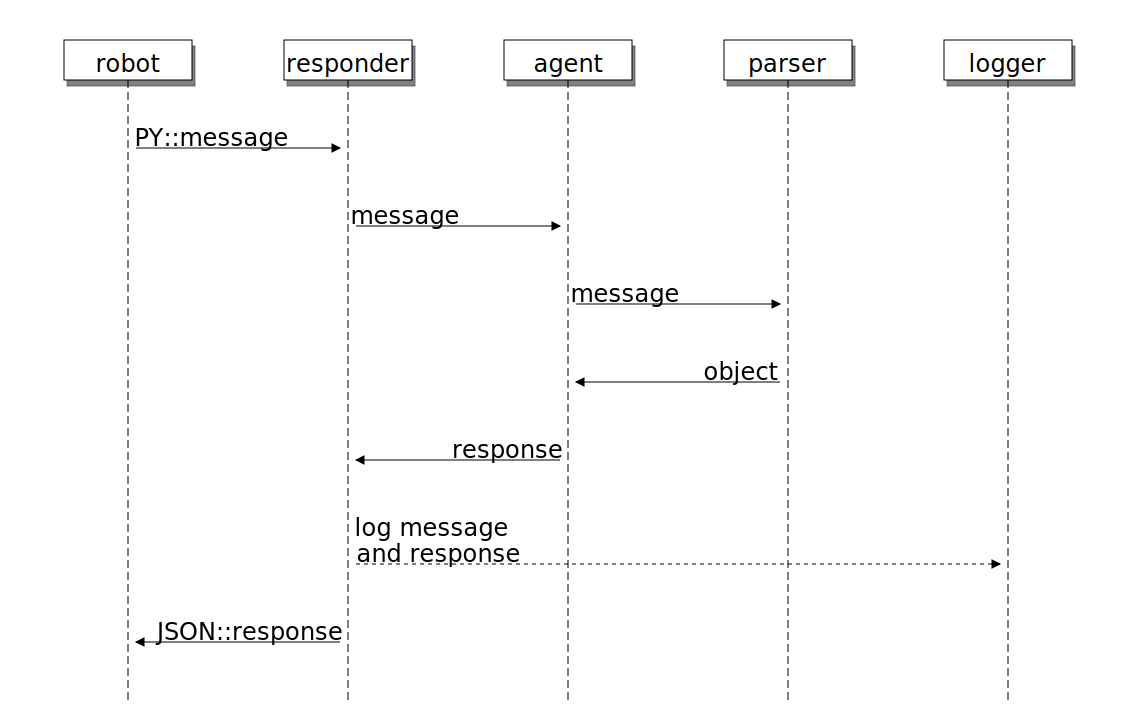

In [15]:
%%seqdiag
default_fontsize = 24;
edge_length = 220;

activation = none;
robot  -> responder [label = "PY::message"];
responder -> agent -> parser [label='message'];
agent <- parser [label='object'];
responder <- agent [label='response'];
responder --> logger [label = "log message\nand response"];
robot <- responder [label = "JSON::response"];

In the sequence diagram, the *robot* passes a message to the *responder*, which passes it on the the *agent*. The agent gets the message parsed by the *parser* and passes a response object back to the *responder*. The *responder* creates a log entry and sends a response back to the *robot*.

Here's an implementation of the JSON message handling responder:

In [16]:
import json

def json_responder(msg_object):
    """Echo the original message as JSON."""
    # Pass the message to an agent who will
    # parse the message, act on itm and provide
    # a response
    agent_response = agent(parser(msg_object))
    
    # Get the agents response and wrap it as a message
    json_data = {'message': agent_response}
    
    # Convert that object to a serialised
    # JSON message (a text string)
    json_string = json.dumps(json_data)
    # On the robot side, we can parse this
    # text message to recreate a Javascript object

    # Create a response that works with
    # our message protocol
    response = f"JSON::{json_string}"
    
    # Write to the logger
    logger(msg, response)
    
    # Return the response
    return response

Let's see how that message handler works on some test messages:

In [17]:
test_messages = ["PY::my message",
                 "PY:: [1,2,3]",
                 'PY::{"key": "value"}',
                 "my message"]

for msg in test_messages:
    print(f'Original: {msg}')
    if json_responder(msg):
        print(f'Response: {json_responder(msg)}\n')

Original: PY::my message
Response: JSON::{"message": "Py saw: my message"}

Original: PY:: [1,2,3]
Response: JSON::{"message": "Py saw: [1, 2, 3]"}

Original: PY::{"key": "value"}
Response: JSON::{"message": "Py saw: {'key': 'value'}"}

Original: my message
Response: JSON::{"message": "Py saw: None"}



In this case, the parser returns a Python object to the responder, which creates a JSON string representation of it that can be passed back to the simulated robot as a simple text message.

Let's hook that responder up as a new responder to the robot's messages:

In [18]:
roboSim.pyresponder = json_responder

# Flush any garbage already on the line...
%sim_magic --refresh

Clear the logfile:

In [19]:
%%writefile logger.txt
# Responder logfile
# -----------------

Overwriting logger.txt


Now let's try out our new responder and see if we can:

- pass a Javascript object from the robot, as a JSON string, to the Python environment;
- decode the string, do something with it, create a JSON encoded response and send it back to the robot;
- parse the received message as a Javascript object.

In [20]:
%%sim_magic_preloaded -ROHW --collab
import ev3dev2_glue as glue
import time

for i in range(5):
    # The robot prints a message
    # This will not be responded to
    print("Robot says", str(i))
    
    if not i%2:
        # Display a message that is sent to Python
        print("PY::"+str(i))
        # Any response will be deisplayed in
        # the output display
    
    # The returned message is added to
    # an internal message queue 
    msg_queue = glue.pyState()
    print('Message queue', msg_queue)
    time.sleep(1)

msg_queue = glue.pyState()
print('Message queue',msg_queue)
print("Last message", msg_queue["messages"][-1])

py_msg = str(msg_queue["messages"][-1]['message'])
say("Last Python message was ..."+py_msg)

When we run this program in the simulator, the robot sends a mesage such as:

`PY::0`

The Python agent receives the message and responds with a message of the form:

`JSON::{"message": "Py saw: 0"}`

The response is decoded by the robot as the Javascript object `{"message": "Py saw: 0"}` and added to the end of a `messages` list. We can then access the messages as required.

Again, we can also view the logfile giving the Python agent's perspective:

In [21]:
%cat logger.txt

# Responder logfile
# -----------------
Received message: my message
Response: JSON::{"message": "Py saw: 0"}
---


### 3.1.4 Extending the message parser

Let's now look at how we might retrieve real time sensor data in out message passing system.

As well as the `PY::` message processor, the robot also has a special `IMG_DATA` message processor.  Printing the message `IMG_DATA` to the simulator output window causes a special message to be passed to the Python environment. This message starts with the phrase `IMG_DATA::`, followed by the sensor data.

We need to extend our parser to handle this message:

In [42]:
def image_parser(msg):
    """Simple message parser with image parsing support."""
    # Match messages that start "PY::" or "IMG_DATA::"
    match = re.search(r'^(IMG_DATA|PY)::(.+)', msg)
    if match:
        matches = match.groups()
        # Get the matched text string
        # Try to cast it to a Python object
        # Note - this is very insecure and not
        # a secure thing to do!
        match_str = matches[1]
        try:
            obj = eval(match_str)
        except:
            obj = match_str
        return {'typ':matches[0], 'obj': obj}
    
    # No match, so return None
    return None

parser = image_parser


Let's just test that:

In [43]:
test_messages = ["PY::1",
                 "PY::[1, 2, 3]",
                 "PY:: {'int': 1, 'str': 'string'}",
                 "PY::my message",
                 "IMG_DATA::{'k1':[1,2,3], 'k2':[4,5,6]}"
                 ]

for msg in test_messages:
    print(f'Original: {msg}')
    if parser(msg):
        print(f'Parsed: {parser(msg)}')
        print(f'Type: {type(parser(msg))}\n')

Original: PY::1
Parsed: {'typ': 'PY', 'obj': 1}
Type: <class 'dict'>

Original: PY::[1, 2, 3]
Parsed: {'typ': 'PY', 'obj': [1, 2, 3]}
Type: <class 'dict'>

Original: PY:: {'int': 1, 'str': 'string'}
Parsed: {'typ': 'PY', 'obj': {'int': 1, 'str': 'string'}}
Type: <class 'dict'>

Original: PY::my message
Parsed: {'typ': 'PY', 'obj': 'my message'}
Type: <class 'dict'>

Original: IMG_DATA::{'k1':[1,2,3], 'k2':[4,5,6]}
Parsed: {'typ': 'IMG_DATA', 'obj': {'k1': [1, 2, 3], 'k2': [4, 5, 6]}}
Type: <class 'dict'>



Observe how our new `image_parser()` function can cope with the original `PY::` prefixed messages and the new `IMG_DATA::` prefixed message type.

Now let's see if we can parse and return some actual image data.

First, clear the log file:

In [44]:
%%writefile logger.txt
# Responder logfile
# -----------------

Overwriting logger.txt


Now let's see if we can collect an image data sample. Note that we are still using the `json_responder()` but with the `image_parser` (as set by `parser = image_parser`).

In [45]:
%%sim_magic_preloaded -b Simple_Shapes --collab -ARO -x 520 -y 900
import time

print("PY::{'test_key':'test value'}")

# Give the messages time to pass
time.sleep(1)
print("IMG_DATA")

time.sleep(1)

You should hopefully see an echo of a large amount of sensor data appear in the simulator output window. We should also be able to see it in the Python log file:

In [46]:
%cat logger.txt

# Responder logfile
# -----------------
Received message: IMG_DATA::{'k1':[1,2,3], 'k2':[4,5,6]}
Response: JSON::{"message": "Py saw: {'typ': 'PY', 'obj': \"{'k':''v}\"}"}
---
Received message: IMG_DATA::{'k1':[1,2,3], 'k2':[4,5,6]}
Response: JSON::{"message": "Py saw: {'typ': 'IMG_DATA', 'obj': {'left': '245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,226,225,255,245,2

### 3.1.5 Activity — Reviewing the inter-agent message protocol and communication activity 

At this point, let's quickly recap on the messaging protocol we have defined by way of another sequence diagram:

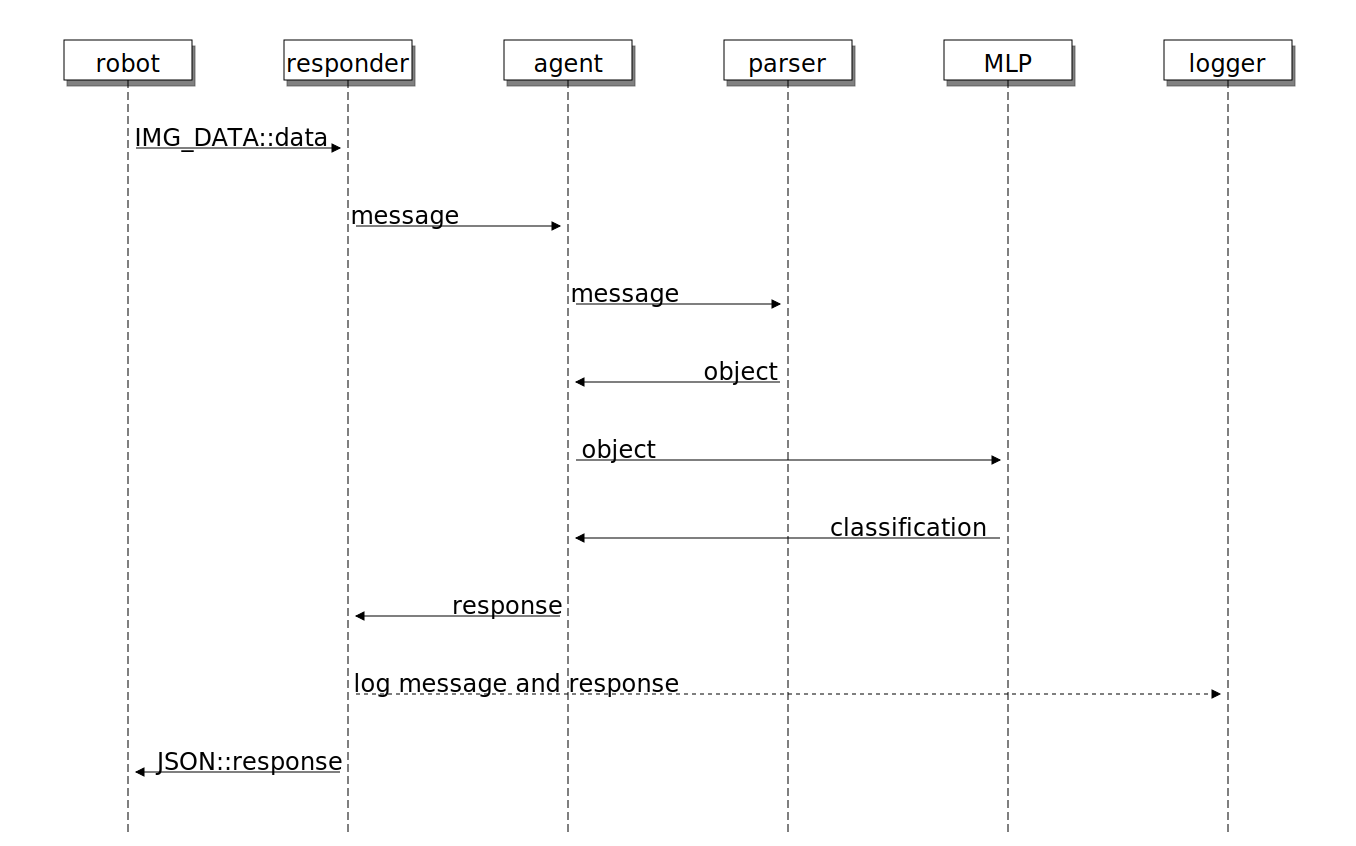

In [47]:
%%seqdiag
default_fontsize = 24;
edge_length = 220;
activation = none;

robot  -> responder [label = "IMG_DATA::data"];
responder -> agent -> parser [label='message'];
agent <- parser [label='object'];
agent -> MLP [label='object'];
agent <- MLP [label='classification'];
responder <- agent [label='response'];
responder --> logger [label = "log message and response"];
robot <- responder [label = "JSON::response"];

*In your own words, describe the sequence of message passing actions depicted by the sequence diagram here.*

#### Example interpretation

*Click on the arrow in the sidebar or run this cell to reveal an example interpretation.*

In the sequence diagram, the *robot* passes a message (`IMG_DATA`) containing image data to the Python *agent*. The *agent* has the message parsed by the *parser*, converts the response to an image pair, and passes one of the images to the *MLP* neural network. The *MLP* classifies the image and returns a prediction to the a *agent*. The *agent* creates a response and passes it to the *responder*, which encodes the response as a text message and sends it to the *robot*. The robot then parses the message as a Javascript object and uses it as required.

## 3.2 Putting the pieces together — a multi-agent system

With our message protocol defined, let's see if we can now create a multi-agent system where the robot collects some image data and passes it to the Python agent. The Python agent should then decode the image data, present it to a pre-trained multi-layer perceptron neural network, and identify a presented shape. The Python agent should then inform the robot about the shape the robot of the object it can see.

### 3.2.1 The image classifier agent

To perform the recognition task, we need to implement our agent. The agent will take the image data and place it in a two row dataframe in the correct form. Then it will generate an image pair from the dataframe, and present the left-hand shape image to the neural network. The neural network will return a shape prediction and this will be passed in a message back to the robot.

First, lets load in a pretrained shape recognising MLP.

In [48]:
from joblib import load

MLP = load('mlp_shapes_14x14.joblib')

And let's set up the category labels:

In [52]:
# Define the classes
shapemap = {'square': 0,
            'right facing triangle': 1,
            'left facing triangle': 2,
            'downwards facing triangle': 3,
            'upwards facing triangle': 4,
            'diamond': 5
           }

codemap = {shapemap[k]:k for k in shapemap}
codemap

{0: 'square',
 1: 'right facing triangle',
 2: 'left facing triangle',
 3: 'downwards facing triangle',
 4: 'upwards facing triangle',
 5: 'diamond'}

In [65]:
import pandas as pd
from nn_tools.sensor_data import get_sensor_image_pair, image_data_to_array
from nn_tools.sensor_data import zoom_img, image_data_to_array, image_from_array

def shape_recognising_agent(msg):
    """Shape recognising agent."""
    if msg['typ'] == 'IMG_DATA':
        pair_index = -1
        image_data = pd.DataFrame([{'side':'left', 'vals': roboSim.process_raw_image_data(msg['obj']['left'])},
                                   {'side':'right', 'vals': roboSim.process_raw_image_data(msg['obj']['right'])}])
        left_img, right_img = get_sensor_image_pair(image_data,
                                            pair_index)
        prediction = class_predict_from_image(MLP, left_img)
    # Suppose we have a dictionary response
    # Just echo that back
    return {'report': f'Agent says: I saw {codemap[prediction]}',
            'shape': codemap[prediction]}

agent = shape_recognising_agent

Now let's see if we can help the robot recognise a shape:

In [67]:
%%sim_magic_preloaded -b Simple_Shapes --collab -ARO -x 520 -y 900
import time

print("IMG_DATA")
# Give the messages time to pass
time.sleep(1)

Let's try another:

In [78]:
%sim_magic --collab -ARO -x 200 -y 900

Let's try a slightly more elaborate handler on the robot side:

In [75]:
%%sim_magic_preloaded -b Simple_Shapes --collab -ARO -x 520 -y 900
import time
import ev3dev2_glue as glue

print("IMG_DATA")
# Give the messages time to pass
time.sleep(1)

msg_queue = glue.pyState()
# Get the last message
possible_shape = msg_queue['messages'][-1]['message']['shape']
say("Is that a " + possible_shape )

Run the following code cell several times to test the robot on different randomly sampled shapes:

In [ ]:
import random
random_shape_x = 200 + random.randint(0, 5)*80

%sim_magic --collab -ARO -x 200 -y 900

*Record your observations here about how well the robot performed.*

*Note down any other ideas you have about how a robot might be able to co-operate with other agents as apart of a multi-agent system.*

## 3.3 Summary

In this notebook, you have seen how we can create a simple protocol that allows the passage of messages between the robot and Python agent in a simple mutli-agent system. The Python agent picks up the message received from the robot, parses it and decodes it as an image. The image is then classified by an MLP and the agent responds to the robot with a predicted image classification.

You also saw how we can use a particular type of diagram, often referred to as a *sequence diagram*, to describe the passage of messages between several different actors in a communication system. Specialised diagram types play a significant role in many engironeering disciplines for depicting in a structured way a visual description of a system or a visual summary of its anticipated operational behaviour. 

Whilst we only considered how our Pyhton agent might call on a neural network to support our remote simulated robot agent, you might also conclude, correctly, that we could also use a "traditional" sequential program, or even a rule based system, to perform "off-board" tasks behalf of the robot.

This largely completes our journey into the world of introductory robot programming and neural networks. All that remains now is for you to read through the final notebook and recap on the journey we have taken over the last few weeks.